In [366]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/gender_submission.csv
/kaggle/input/titanic/test.csv


In [367]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from sklearn.feature_selection import SelectKBest
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate
from collections import Counter
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

# Introduction

This jupyter notebook will go over all the basic steps in-depth while given a certain machine learning problem.

* Aquiring Data and analyzing the dataset
* EDA - Exploratory data analysis
* Data cleaning 
* Feature tuning
* Basic Modeling and hyperparameter optimization
* Voting classifiers and optimized models

# Dataset

We will be going over the kaggle titanic survival probability dataset 

**TASK** - Calculate the survival probability of a passenger list (given in test.csv)

**Scoring** - Accuracy will be the scoring criteria

# Aquiring Data

We'll first read the csv(comma separated values) files into a training and testing dataframes which we can manipulate for analysis and predictions

In [368]:
#Reading data in the .csv format (no special encoding schemes required)

df_train = pd.read_csv('../input/titanic/train.csv')
df_test = pd.read_csv('../input/titanic/test.csv')
id_t = df_test['PassengerId']
print(df_train.shape)
print(df_test.shape)

(891, 12)
(418, 11)


Checking the datatype of the respective columns 

In [369]:
#Datatypes of the training set - Categorical and numerical variables

df_train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

**Outlier detection**

In [450]:
#Outlier detection using the Tukey method

def detect(dataframe,n,features):
    ind = []
    for column in features:
        q1 = np.percentile(dataframe[column],25)
        q3 = np.percentile(dataframe[column],75)
        res = q3 - q1
        new = 1.5 * res
        out = dataframe[(dataframe[column]<q1 - new) | (dataframe[column] >q3 + new)].index
        ind.extend(out)
    ind = Counter(ind)
    val = list(s for s,i in ind.items() if i>n)
    return val

#Detecting outliers for the numerical features
ott = detect(df_train,2,["Age","SibSp","Parch","Fare"])

[7, 16, 24, 50, 59, 63, 68, 71, 85, 119, 164, 171, 176, 182, 229, 233, 261, 266, 278, 374, 386, 409, 480, 485, 541, 542, 634, 642, 683, 686, 726, 787, 813, 819, 824, 850, 7, 8, 10, 13, 16, 24, 25, 43, 50, 54, 58, 59, 63, 65, 68, 71, 78, 86, 93, 97, 98, 102, 118, 119, 124, 128, 136, 140, 145, 147, 148, 153, 155, 160, 164, 165, 166, 167, 171, 172, 175, 176, 182, 183, 184, 188, 193, 197, 205, 229, 233, 237, 247, 248, 251, 254, 255, 259, 261, 262, 266, 268, 272, 273, 278, 279, 297, 299, 305, 311, 312, 314, 318, 319, 323, 328, 329, 332, 340, 348, 352, 356, 360, 362, 374, 377, 381, 386, 390, 394, 407, 409, 416, 417, 419, 423, 424, 435, 436, 437, 438, 440, 445, 446, 448, 450, 469, 472, 479, 480, 485, 489, 498, 506, 523, 529, 530, 532, 533, 535, 539, 540, 541, 542, 548, 549, 550, 558, 567, 580, 581, 585, 587, 593, 595, 600, 608, 610, 615, 616, 618, 622, 634, 637, 638, 642, 644, 651, 657, 659, 670, 678, 679, 683, 684, 685, 686, 689, 691, 698, 702, 709, 720, 736, 742, 745, 746, 750, 751, 754, 75

Outliers can have dramatic effects on our predictions and can also result in harming our final result. We find outliers for the numerical features in the given dataset and we outlined rows with atleast two outliers

In [371]:
#Our final outliers - can have a harmful effect on regression tasks
df_train.loc[ott]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


These rows were identified as outliers according to our given function so we will proceed to drop them from our dataframe

In [372]:
df_train.drop(ott,axis=0,inplace=True) #dropping on the row axis

Create a final dataset (used while feature tuning and cleaning) by combining the training and testing dataframe

In [373]:
#Dataset combining both the training and testing datasets
t_len = len(df_train)
final = pd.concat([df_train,df_test],axis=0).reset_index(drop=True)
final.shape

(1299, 12)

# Analyzing the dataset

Viewing the first 5 rows of the dataset

In [374]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


List of columns present in the dataset

In [375]:
df_train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [376]:
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


**Checking for NULL values**

Multiple NULL values present in Age and Cabin while only 2 in the Embarked column.

In [377]:
df_train.info()
df_train.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 881 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  881 non-null    int64  
 1   Survived     881 non-null    int64  
 2   Pclass       881 non-null    int64  
 3   Name         881 non-null    object 
 4   Sex          881 non-null    object 
 5   Age          711 non-null    float64
 6   SibSp        881 non-null    int64  
 7   Parch        881 non-null    int64  
 8   Ticket       881 non-null    object 
 9   Fare         881 non-null    float64
 10  Cabin        201 non-null    object 
 11  Embarked     879 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 89.5+ KB


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            170
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          680
Embarked         2
dtype: int64

In [378]:
df_test.info()
df_test.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

The describe method provides us a brief summary of basic statistical measures such as quartiles, mean, count etc.

In [379]:
#Brief statistics
df_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,881.000000,881.000000,881.000000,711.000000,881.000000,881.000000,881.000000
mean,446.713961,0.385925,2.307605,29.731603,0.455165,0.363224,31.121566
std,256.617021,0.487090,0.835055,14.547835,0.871571,0.791839,47.996249
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,226.000000,0.000000,2.000000,20.250000,0.000000,0.000000,7.895800
50%,448.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.000000,1.000000,3.000000,38.000000,1.000000,0.000000,30.500000
max,891.000000,1.000000,3.000000,80.000000,5.000000,6.000000,512.329200


In [380]:
df_test.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


# EDA (exploratory data analysis)

Checking the correlation among the numerical variables present in the dataset

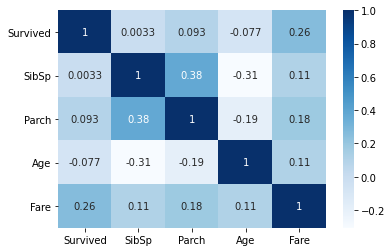

In [381]:
#Correlation between numerical values

hm = sns.heatmap(df_train[['Survived','SibSp','Parch','Age','Fare']].corr(),annot=True,cmap='Blues')

We see that there's high correlation only between fare and survival probabilities, this feature may turn out to be our main focus

In [382]:
df_train[['Sex','Survived']].groupby(['Sex'],as_index=False).mean().sort_values(by='Survived',ascending=False)

,Sex,Survived
0,female,0.747573
1,male,0.190559


There is a much higher probability of females surviving on the Titanic than men, Let us now proceed to visualize it.

Text(0.5, 0, 'Sex')

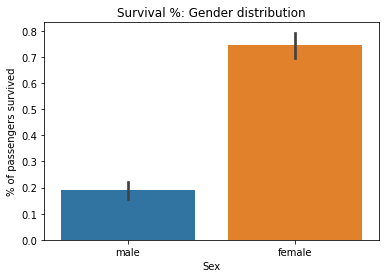

In [383]:
#Plot for gender distribition of survival rate
sns.barplot(x='Sex',y='Survived',data=df_train)
plt.title('Survival %: Gender distribution')
plt.ylabel('% of passengers survived')
plt.xlabel('Sex')

We can clearly see that gender plays a huge role in calculating the survival probability for a passenger. This is a crucial feature that would help to improve upon our predictions.

We will now visualize the total passenger count according to gender and survivability.

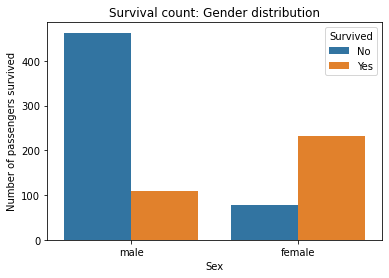

In [384]:
#Survivor count for each gender
m = sns.countplot(x='Sex',hue='Survived',data=df_train)
plt.title('Survival count: Gender distribution')
plt.xlabel('Sex')
plt.ylabel('Number of passengers survived')
a = m.get_legend()
b = a.texts
b[0].set_text('No')
b[1].set_text('Yes')

Again, we see that there is a large difference between the number of survivors between both of the genders.

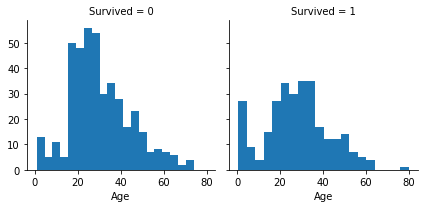

In [385]:
#Age survival ratio
s = sns.FacetGrid(df_train,col='Survived')
s.map(plt.hist,'Age',bins=20)

It seems that the middle-aged and old people had a very low survival probability as compared to infants, childrens and young adults. Age plays an important role in saving yourself during a time of crisis.

Text(0.5, 0, 'Passenger class')

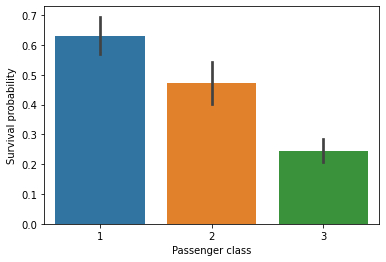

In [386]:
#Survival probability vs Class
b = sns.barplot(x='Pclass',y='Survived',data=df_train)
b.set_ylabel('Survival probability')
b.set_xlabel('Passenger class')

Text(0.5, 0, 'Pclass')

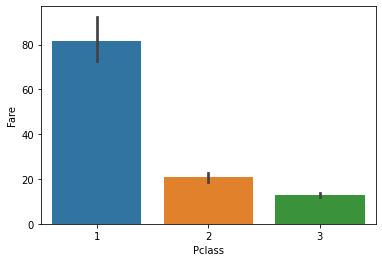

In [387]:
c = sns.barplot(x='Pclass',y='Fare',data=df_train)
c.set_ylabel('Fare')
c.set_xlabel('Pclass')

It seems that the rich people present in Passenger Class 1 had a much higher probability of survival in comparison to the other passenger classes. The fare is proportional to the survivability result.

Text(0.5, 0, 'Passenger class')

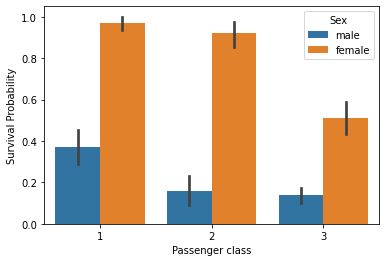

In [388]:
#Survival Probability vs Class and Sex
b = sns.barplot(x='Pclass',y='Survived',hue='Sex',data=df_train)
b.set_ylabel('Survival Probability')
b.set_xlabel('Passenger class')

We observe a similar trend here where the survival probability is in direct correlation with the gender as well as the Passenger class. Higher the passenger class equalled low fare which results in low survival chance.

Text(0.5, 0, 'Embarked')

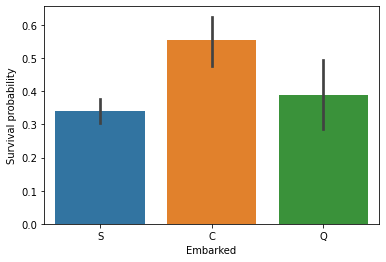

In [389]:
#Exploring Embarked vs Survival probability
ax = sns.barplot(x='Embarked',y='Survived',data=df_train)
ax.set_ylabel('Survival probability')
ax.set_xlabel('Embarked')

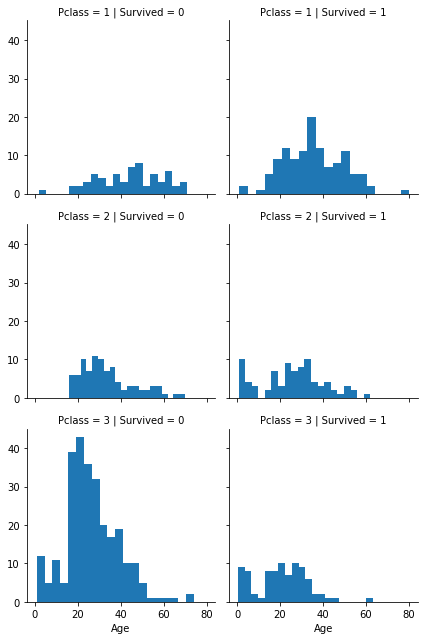

In [390]:
g1 = sns.FacetGrid(df_train,col='Survived',row='Pclass')
g1.map(plt.hist,'Age',bins=20)

We see that Pclass 1 consists of more middle-aged and old men while P-class 2 and 3 consist of infants, children and the like. It is a similar occurence in real-life where usually old and rich people travel in First-Class with the presenece of children being very rare.

We also see that the survived histogram dwindles down in height as we move lower down the graph. The histogram still rises up pretty well for the lower age group which is what we saw above as well. Children, teenagers and young adults have a higher survival rate than the middle-aged and old people.

Text(0.5, 0, 'Fare distribution')

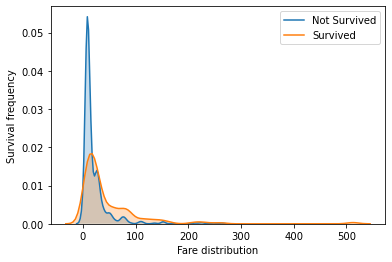

In [391]:
#Fare distribution
a1 = sns.kdeplot(df_train.loc[(df_train['Survived']==0),'Fare'],shade=True,label='Not Survived')
a1 = sns.kdeplot(df_train.loc[(df_train['Survived']==1),'Fare'],shade=True,label='Survived')
plt.ylabel('Survival frequency')
plt.xlabel('Fare distribution')

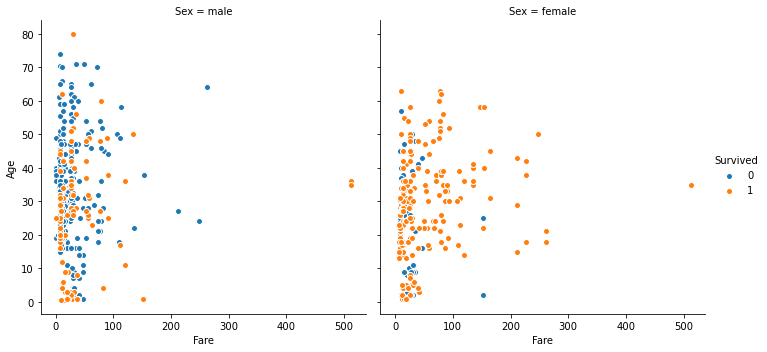

In [392]:
#Survival by Fare,Age and Sex
s = sns.FacetGrid(df_train,size=5,hue='Survived',col='Sex')
s.map(plt.scatter,'Fare','Age',edgecolor='w').add_legend()

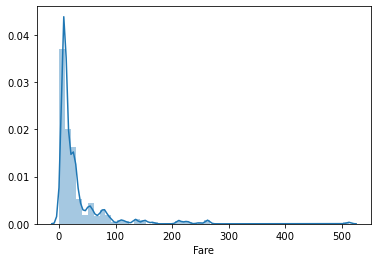

In [393]:
#Plotting fare in the combined dataset
s = sns.distplot(final['Fare'])

# Data cleaning

We see that the fare distribution is very skewed: It can result in some weight differences in the model. 

In [394]:
final['log_Fare'] = final['Fare'].map(lambda n: np.log(n) if n>0 else 0)

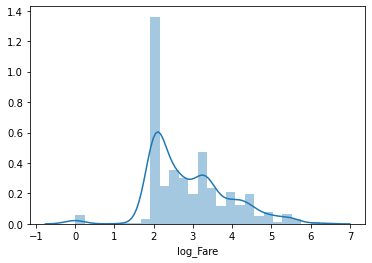

In [395]:
#Log mapped fare values
sns.distplot(final['log_Fare'])

1. **Dealing with NULL values in the respective columns**

In [396]:
final.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             256
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1007
Embarked          2
log_Fare          0
dtype: int64

<h3>Fare</h3>

In [397]:
#As we have only 1 null value, we can just fill it up with the median value taking into account the rest of the features
fare=final.loc[(final['Embarked'] == "S") & (final['Pclass'] == 3), 'Fare'].median()
final['Fare']=final['Fare'].fillna(fare)

<h3>Embarked</h3>

**We will first deal with the Embarked column with 2 NULL values**

In [398]:
final[final['Embarked'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,log_Fare
60,62,1.0,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN,4.382027
821,830,1.0,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN,4.382027


All the missing values have Sex: Female, Pclass: 1 and fare: 80, let us look at the relation between Fare and embarked

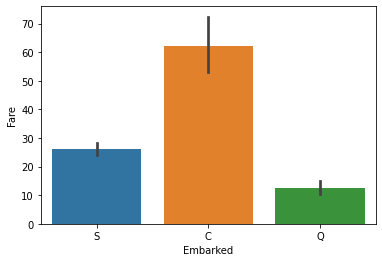

In [399]:
sns.barplot(x='Embarked',y='Fare',data=final)

We see that the fare values of C are nearest to 80, therefore we fill the given columns with 'C' embarked

In [400]:
#Replacing the NULL values with C
final['Embarked']=final['Embarked'].fillna('C')
final[final['Embarked'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,log_Fare


<h3>Cabin</h3>

Going over the cabin column for NULL values

In [401]:
final['Cabin'].isnull().sum()

1007

In [402]:
final['Cabin'].describe()

count                 292
unique                186
top       B57 B59 B63 B66
freq                    5
Name: Cabin, dtype: object

We proceed to check the unique values for the Cabin column

In [403]:
final['Cabin'].unique()

array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6', 'B78', 'D33',
       'B30', 'C52', 'B28', 'C83', 'F33', 'F G73', 'E31', 'A5', 'D10 D12',
       'D26', 'C110', 'B58 B60', 'E101', 'F E69', 'D47', 'B86', 'F2',
       'C2', 'E33', 'B19', 'A7', 'C49', 'F4', 'A32', 'B4', 'B80', 'A31',
       'D36', 'D15', 'C93', 'C78', 'D35', 'C87', 'B77', 'E67', 'B94',
       'C125', 'C99', 'C118', 'D7', 'A19', 'B49', 'D', 'C22 C26', 'C106',
       'C65', 'E36', 'C54', 'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18',
       'C124', 'C91', 'E40', 'T', 'C128', 'D37', 'B35', 'E50', 'C82',
       'B96 B98', 'E10', 'E44', 'C23 C25 C27', 'A34', 'C104', 'C111',
       'C92', 'E38', 'D21', 'E12', 'E63', 'A14', 'B37', 'C30', 'D20',
       'B79', 'E25', 'D46', 'B73', 'C95', 'B38', 'B39', 'B22', 'C86',
       'C70', 'A16', 'C101', 'C68', 'A10', 'E68', 'B41', 'A20', 'D19',
       'D50', 'D9', 'A23', 'B50', 'A26', 'D48', 'E58', 'C126', 'B71',
       'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63', 'C62 C64', 'E24',

To fill the NULL values, we observe that not everyone as a passenger is given a cabin while on a ship.The titanic had a very huge passenger count and it probably wasn't possible to assign each and every one a separate cabin, therefore we can just give it a value 'O' to define no cabin associated.

In [404]:
final['Cabin'] = final['Cabin'].fillna('O')

In [405]:
final['Cabin'] = pd.Series(a[0] for a in final['Cabin'])

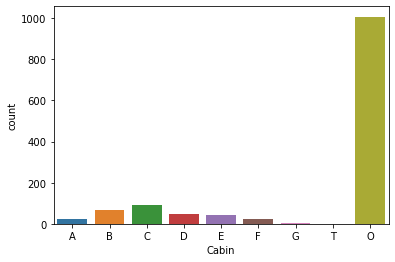

In [406]:
sns.countplot(final['Cabin'],order=['A','B','C','D','E','F','G','T','O'])

In [407]:
final = pd.get_dummies(final,columns=['Cabin'],prefix='Cabin')

<h3>Age</h3>

In [408]:
#Percentage of values missing in the whole dataset
print('% of missing age data',(final.Age.isnull().sum()/len(final.Age)))

% of missing age data 0.19707467282525018


Age is one of the key factors while dealing with survival rates. We cannot simply impute it with other values. We can make a regressor that predicts the age values through the other numerical values

**Building a random forest regressor to predict age through the other features**

In [409]:
from sklearn.ensemble import RandomForestRegressor

mini = final[['Age','Sex','Pclass','Parch','SibSp']]
mini = pd.get_dummies(mini)
train = mini[mini.Age.notnull()].to_numpy()
test = mini[mini.Age.isnull()].to_numpy()
y = train[:,0]
x = train[:,1:]
clf = RandomForestRegressor(n_estimators=150,n_jobs=-1,random_state=0)
clf.fit(x,y)
predicts = clf.predict(test[:,1:])
final.loc[(final.Age.isnull()),'Age'] = predicts

In [410]:
final.Age.isnull().sum()

0

# Feature modelling

<h3>Prefix/Title</h3>

In [411]:
#Each name has a title associated with it - Could give important information
final['Name']

0                                 Braund, Mr. Owen Harris
1       Cumings, Mrs. John Bradley (Florence Briggs Th...
2                                  Heikkinen, Miss. Laina
3            Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                                Allen, Mr. William Henry
                              ...                        
1294                                   Spector, Mr. Woolf
1295                         Oliva y Ocana, Dona. Fermina
1296                         Saether, Mr. Simon Sivertsen
1297                                  Ware, Mr. Frederick
1298                             Peter, Master. Michael J
Name: Name, Length: 1299, dtype: object

The title of a person may hold great value while calculating survival predictions. People of higher status may be rescued first and others with titles corresponding to armies or the crew end up in the other side of the spectrum.

In [412]:
final_title = [a for i in final['Name'] for a in i.split(' ') if a.endswith('.')]
final['prefix'] = pd.Series(final_title)
final['prefix'].head()

0      Mr.
1     Mrs.
2    Miss.
3     Mrs.
4      Mr.
Name: prefix, dtype: object

Visualizing the different titles present on the ship

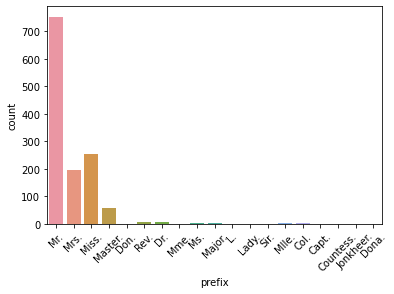

In [413]:
g = sns.countplot(x='prefix',data=final)
g = plt.setp(g.get_xticklabels(),rotation=45)

In [414]:
final['prefix'].unique()

array(['Mr.', 'Mrs.', 'Miss.', 'Master.', 'Don.', 'Rev.', 'Dr.', 'Mme.',
       'Ms.', 'Major.', 'L.', 'Lady.', 'Sir.', 'Mlle.', 'Col.', 'Capt.',
       'Countess.', 'Jonkheer.', 'Dona.'], dtype=object)

Many of the titles are quite similar in nature and we can group them up to prevent giving rise to further features while one-hot encoding the whole dataset.

In [415]:
name_mapping = {
    "Capt.": "Officer",
    "Col.": "Officer",
    "Major.": "Officer",
    "Jonkheer.": "Master",
    "Don.": "Royalty",
    "Sir." : "Royalty",
    "Dr.": "Officer",
    "Rev.": "Officer",
    "the Countess.":"Royalty",
    "Mme.": "Mrs",
    "Mlle.": "Miss",
    "Ms.": "Mrs",
    "Mr." : "Mr",
    "Mrs." : "Mrs",
    "Miss." : "Miss",
    "Master." : "Master",
    "Lady." : "Royalty",
    "Dona." : "Royalty" 
}
final['prefix']=final['prefix'].map(name_mapping)
final['prefix']

0            Mr
1           Mrs
2          Miss
3           Mrs
4            Mr
         ...   
1294       Miss
1295         Mr
1296    Royalty
1297         Mr
1298         Mr
Name: prefix, Length: 1299, dtype: object

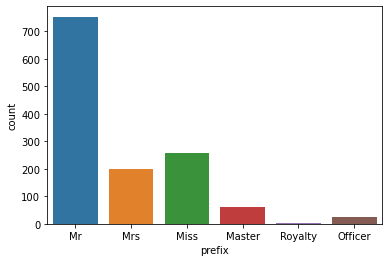

In [416]:
g = sns.countplot(final['prefix'])

In [417]:
final.drop(['Name'],axis=1,inplace=True)

<h3>Family size</h3>

**Family size**: New feature containing the siblings and parents

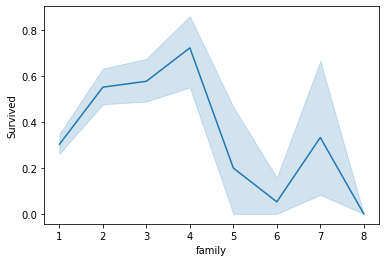

In [418]:
final['family'] = final['SibSp'] + final['Parch'] + 1
g = sns.lineplot(x='family',y='Survived',data=final)

Converting family to categorical variables:

In [419]:
final['Single'] = final['family'].map(lambda s: 1 if s==1 else 0)
final['small'] = final['family'].map(lambda s:1 if s==2 else 0)
final['medium'] = final['family'].map(lambda s:1 if 3<=s<=4 else 0)
final['large'] = final['family'].map(lambda s:1 if s>=5 else 0)

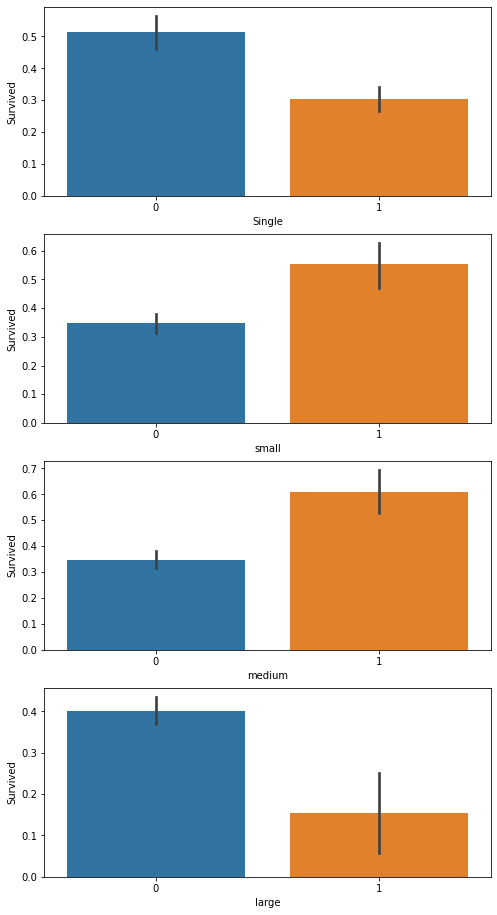

In [420]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1,figsize=(8,16))

p = sns.barplot(x='Single',y='Survived',data=final,ax=ax1)
q = sns.barplot(x='small',y='Survived',data=final,ax=ax2)
r = sns.barplot(x='medium',y='Survived',data=final,ax=ax3)
s = sns.barplot(x='large',y='Survived',data=final,ax=ax4)

<h3>Ticket Prefix</h3>

Analyzing the ticket column

In [421]:
final['Ticket'].head()

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
Name: Ticket, dtype: object

In [422]:
#Extracting the prefix of the tickets
Ticket = []
for i in list(final.Ticket):
    if not i.isdigit() :
        Ticket.append(i.replace(".","").replace("/","").strip().split(' ')[0]) #Take prefix
    else:
        Ticket.append("X")

final['Ticket'] = Ticket
final['Ticket'].head()

0        A5
1        PC
2    STONO2
3         X
4         X
Name: Ticket, dtype: object

In [423]:
final.drop(['Fare'],axis=1,inplace=True)

<h3>One hot encoding remaining columns</h3>

We will proceed to use one-hot encoding to further encode our other categorical variables. We use different prefix to separate out any similarities after encoding.

In [424]:
final = pd.get_dummies(final,columns=['prefix'])
final = pd.get_dummies(final,columns=['Embarked'],prefix='Em')

In [425]:
final = pd.get_dummies(final,columns=['Ticket'],prefix='T')

In [426]:
final['Pclass'] = final['Pclass'].astype('category')
final = pd.get_dummies(final,columns=['Pclass'],prefix='Pc')

In [427]:
#Map sex to numerical variables
final["Sex"] = final["Sex"].map({"male": 0, "female":1})

In [428]:
modelling = final.drop(['PassengerId'],axis=1)

# ML model

In [429]:
training = modelling[:t_len]
test = modelling[t_len:]
test.drop(['Survived'],axis=1,inplace=True)

In [430]:
training['Survived'] = training['Survived'].astype(int)
y_train = training['Survived']
x_train = training.drop(['Survived'],axis=1)

In [431]:
x_train.head()

,Sex,Age,SibSp,Parch,log_Fare,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,...,T_STONO,T_STONO2,T_STONOQ,T_SWPP,T_WC,T_WEP,T_X,Pc_1,Pc_2,Pc_3
0,0,22.0,1,0,1.981001,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,1,38.0,1,0,4.266662,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,1,26.0,0,0,2.070022,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
3,1,35.0,1,0,3.972177,0,0,1,0,0,...,0,0,0,0,0,0,1,1,0,0
4,0,35.0,0,0,2.085672,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1


In [432]:
y_train.shape

(881,)

In [433]:
kfold = StratifiedKFold(n_splits=10)

In [434]:
random_state = 0
models = []
models.append(SVC(random_state=random_state))
models.append(DecisionTreeClassifier(random_state=random_state))
models.append(AdaBoostClassifier(random_state=random_state))
models.append(RandomForestClassifier(random_state=random_state))
models.append(ExtraTreesClassifier(random_state=random_state))
models.append(GradientBoostingClassifier(random_state=random_state))
models.append(MLPClassifier(random_state=random_state))
models.append(KNeighborsClassifier())
models.append(LogisticRegression(random_state = random_state))
models.append(XGBClassifier(random_state = random_state))

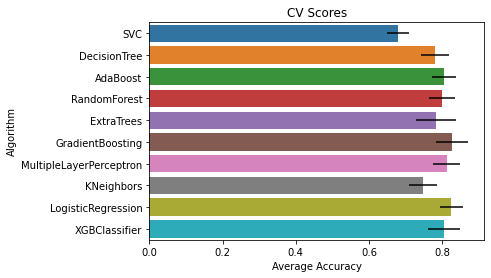

In [435]:
crossval = []
for classifier in models:
    crossval.append(cross_val_score(classifier,x_train,y=y_train,scoring='accuracy',cv=kfold))
cv_mean = []
cv_std = []
for res in crossval:
    cv_mean.append(res.mean())
    cv_std.append(res.std())

cross_val_df = pd.DataFrame({'CVMean':cv_mean,'CVErrors':cv_std,'Algorithm':["SVC","DecisionTree","AdaBoost","RandomForest","ExtraTrees","GradientBoosting","MultipleLayerPerceptron","KNeighbors","LogisticRegression","XGBClassifier"]})
ax = sns.barplot('CVMean','Algorithm',data=cross_val_df,**{'xerr':cv_std})
ax.set_xlabel('Average Accuracy')
ax = ax.set_title("CV Scores")

Here, we achieve high performance with logistic regression, XGBClassifier, Gradient Boosting and Random forests.
We will choose these models for our voting classifier

# Fine tuning individual models

In [436]:
gbc = GradientBoostingClassifier()
param_grid = {'loss':['exponential'],
             'n_estimators':[150,200,250],
             'learning_rate':[0.1,0.05,0.01],
             'max_depth':[4,8,10],
             'min_samples_leaf':[50,100],
             'max_features':[0.5,0.4,0.3]
             }

GBC_cv = GridSearchCV(gbc,param_grid=param_grid,cv=kfold,scoring='accuracy',n_jobs=4,verbose=1)
GBC_cv.fit(x_train,y_train)
print(GBC_cv.best_params_)
GBC_b = GBC_cv.best_estimator_
print(GBC_cv.best_score_)

Fitting 10 folds for each of 162 candidates, totalling 1620 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    6.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   23.3s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   55.8s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:  1.6min
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:  2.5min
[Parallel(n_jobs=4)]: Done 1620 out of 1620 | elapsed:  3.3min finished


{'learning_rate': 0.1, 'loss': 'exponential', 'max_depth': 4, 'max_features': 0.5, 'min_samples_leaf': 50, 'n_estimators': 150}
0.8377042900919307


In [437]:
xgb = XGBClassifier()
param_grid = {
    'min_child_weight': [1, 5, 10],
    'gamma': [0.5, 1, 1.5, 2, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'max_depth': [3, 4, 5]
}
xgb_cv = GridSearchCV(xgb,param_grid=param_grid,cv=kfold,scoring='accuracy',n_jobs=4,verbose=1)
xgb_cv.fit(x_train,y_train)
print(xgb_cv.best_params_)
xgb_b = xgb_cv.best_estimator_

Fitting 10 folds for each of 405 candidates, totalling 4050 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   12.5s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   28.2s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:   51.8s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed:  2.0min
[Parallel(n_jobs=4)]: Done 2442 tasks      | elapsed:  2.9min
[Parallel(n_jobs=4)]: Done 3192 tasks      | elapsed:  3.9min
[Parallel(n_jobs=4)]: Done 4042 tasks      | elapsed:  5.2min


{'colsample_bytree': 0.8, 'gamma': 1, 'max_depth': 4, 'min_child_weight': 5, 'subsample': 0.8}


[Parallel(n_jobs=4)]: Done 4050 out of 4050 | elapsed:  5.2min finished


In [438]:
lr = LogisticRegression()
param_grid = {
    'penalty' : ['l1', 'l2'],
    'C' : np.logspace(-4, 4, 30)
}
lr_cv = GridSearchCV(lr,param_grid=param_grid,cv=kfold,scoring='accuracy',n_jobs=4,verbose=1)
lr_cv.fit(x_train,y_train)
print(lr_cv.best_params_)
lr_b = lr_cv.best_estimator_

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 10 folds for each of 60 candidates, totalling 600 fits


[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    2.6s


{'C': 1.3738237958832638, 'penalty': 'l2'}


[Parallel(n_jobs=4)]: Done 600 out of 600 | elapsed:    6.4s finished


In [439]:
# rf = RandomForestClassifier()

# param_grid = {
#     "max_depth": [None],
#     "max_features": [1,3,5,710],
#     "min_samples_split": [2,3,5,7,10],
#     "min_samples_leaf": [1,2,3,5,10],
#     "bootstrap": [False],
#     "n_estimators" :[100,150,200,300],
#     "criterion": ["gini"]
# }
# rf_cv = GridSearchCV(rf,param_grid=param_grid,cv=kfold,scoring='accuracy',n_jobs=4,verbose=1)
# rf_cv.fit(x_train,y_train)
# print(rf_cv.best_params_)
# rf_b = rf_cv.best_estimator_
# print(rf_cv.best_score_)

mp = MLPClassifier()
param_grid = {'solver': ['lbfgs'], 'max_iter': [500,1000,1500], 'alpha': 10.0 ** -np.arange(1, 7), 'hidden_layer_sizes':np.arange(5, 12)}
mp_cv = GridSearchCV(mp,param_grid=param_grid,cv=kfold,scoring='accuracy',n_jobs=4,verbose=1)
mp_cv.fit(x_train,y_train)
print(mp_cv.best_params_)
mp_b = mp_cv.best_estimator_
print(mp_cv.best_score_)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 10 folds for each of 126 candidates, totalling 1260 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  2.3min
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:  4.0min
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:  6.2min
[Parallel(n_jobs=4)]: Done 1260 out of 1260 | elapsed:  6.4min finished


{'alpha': 0.001, 'hidden_layer_sizes': 11, 'max_iter': 500, 'solver': 'lbfgs'}
0.8252298263534218


# Exploring Feature importance of the classifiers

Text(0.5, 1.0, 'Adaboost Feature importance')

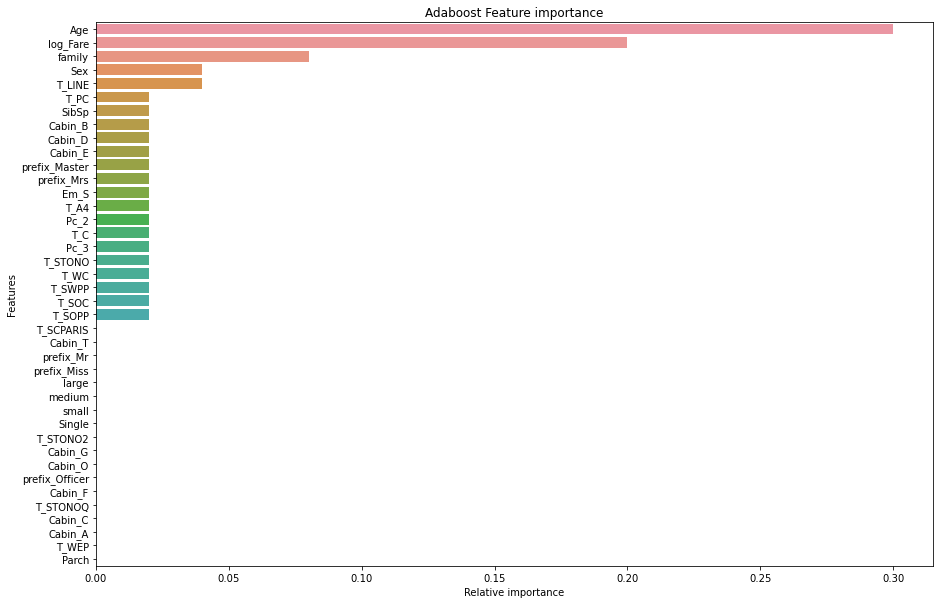

In [440]:
ada = AdaBoostClassifier()
ada.fit(x_train,y_train)
l1 = np.argsort(ada.feature_importances_)[::-1][:40]
plt.figure(figsize=(15,10))
g1 = sns.barplot(y=x_train.columns[l1][:40],x=ada.feature_importances_[l1][:40],orient='h')
g1.set_xlabel('Relative importance')
g1.set_ylabel('Features')
g1.set_title('Adaboost Feature importance')

Text(0.5, 1.0, 'ExtraTreesClassifier Feature importance')

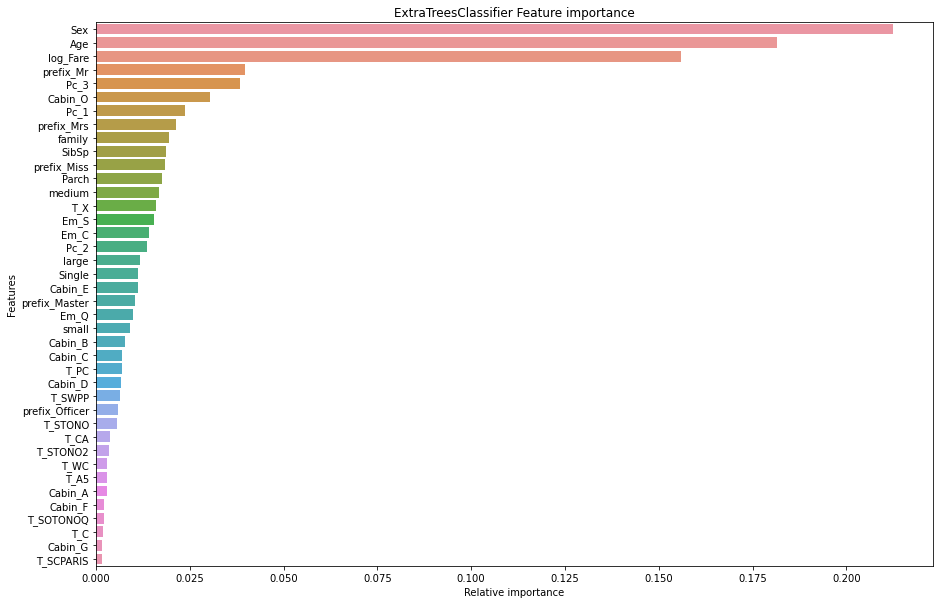

In [441]:
etc = ExtraTreesClassifier()
etc.fit(x_train,y_train)
e1 = np.argsort(etc.feature_importances_)[::-1][:40]
plt.figure(figsize=(15,10))
g2 = sns.barplot(y=x_train.columns[e1][:40],x=etc.feature_importances_[e1][:40],orient='h')
g2.set_xlabel('Relative importance')
g2.set_ylabel('Features')
g2.set_title('ExtraTreesClassifier Feature importance')

Text(0.5, 1.0, 'Random forest Feature importance')

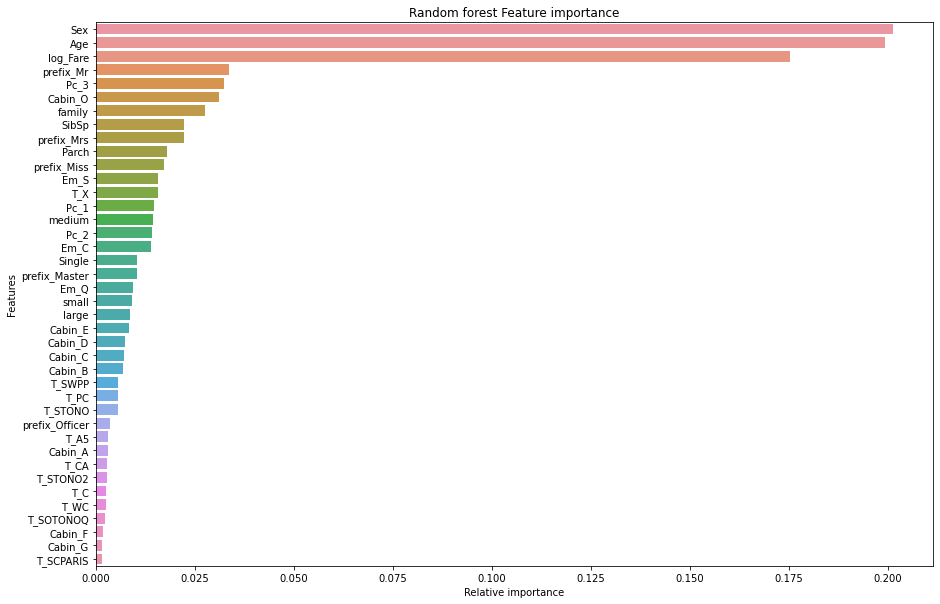

In [442]:
rf_b = RandomForestClassifier()
rf_b.fit(x_train,y_train)
f1 = np.argsort(rf_b.feature_importances_)[::-1][:40]
plt.figure(figsize=(15,10))
g3 = sns.barplot(y=x_train.columns[f1][:40],x=rf_b.feature_importances_[f1][:40],orient='h')
g3.set_xlabel('Relative importance')
g3.set_ylabel('Features')
g3.set_title('Random forest Feature importance')

Text(0.5, 1.0, 'Random forest Feature importance')

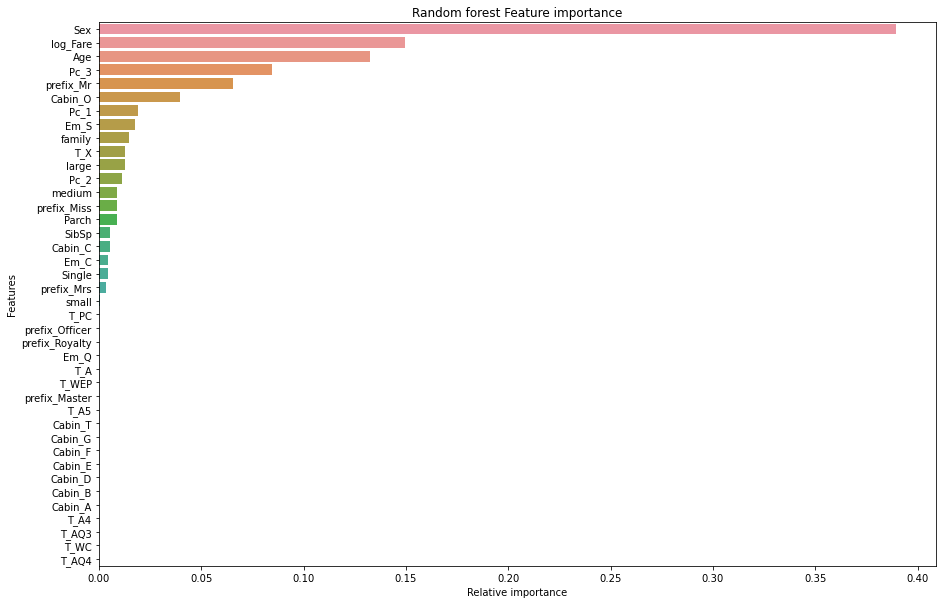

In [443]:
z1 = np.argsort(GBC_b.feature_importances_)[::-1][:40]
plt.figure(figsize=(15,10))
g4 = sns.barplot(y=x_train.columns[z1][:40],x=GBC_b.feature_importances_[z1][:40],orient='h')
g4.set_xlabel('Relative importance')
g4.set_ylabel('Features')
g4.set_title('Random forest Feature importance')

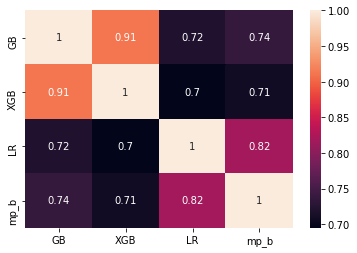

In [444]:
ts_gbc = pd.Series(GBC_b.predict(test),name='GB')
ts_xgb = pd.Series(xgb_b.predict(test),name='XGB')
ts_lr = pd.Series(lr_b.predict(test),name='LR')
ts_mp = pd.Series(mp_b.predict(test),name='mp_b')
ensembled = pd.concat([ts_gbc,ts_xgb,ts_lr,ts_mp],axis=1)
hm = sns.heatmap(ensembled.corr(),annot=True)

In [445]:
vc_soft = VotingClassifier(estimators=[('XBG',xgb_b),('GB',GBC_b),('LR',lr_b),('MP',mp_b)],voting='hard',n_jobs=4)
vc_soft = vc_soft.fit(x_train,y_train)

In [446]:
result = pd.Series(vc_soft.predict(test),name='Survived')
results = pd.concat([id_t,result],axis=1)
results.to_csv('mp_hard_voting.csv',index=False)

In [447]:
results.shape

(418, 2)